In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import neurokit2 as nk
import math
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.utils import np_utils
import scipy.io as sio
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib

In [2]:
datalen = 1800
# 每段資料長度
datanum = 90
# 每人幾段資料

In [3]:
data = pd.read_csv('data_id.csv', header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,3591,3592,3593,3594,3595,3596,3597,3598,3599,3600
0,145.164168,145.165019,145.166677,145.168670,145.170431,145.172727,145.175902,145.179267,145.182752,145.195770,...,142.757597,141.706832,140.471817,139.052005,137.426833,135.593018,134.583502,135.192032,137.401819,0.0
1,146.510569,146.494195,146.485098,146.483633,146.489449,146.501948,146.524060,146.557653,146.601875,146.657552,...,135.716001,134.857977,133.844165,132.652239,131.266681,129.663971,127.820864,127.163710,128.784915,0.0
2,141.636752,141.637088,141.649500,141.677392,141.717460,141.767372,141.832383,141.913798,142.007577,142.112366,...,144.240622,144.077444,143.831753,143.605966,143.400955,143.235656,143.165471,143.148708,143.183299,0.0
3,142.615959,142.643841,142.675440,142.716516,142.768676,142.834301,142.917038,143.011041,143.113161,143.228099,...,141.863198,141.650488,141.441162,141.191843,141.011879,141.013720,141.097267,141.268441,141.487353,0.0
4,145.129076,145.127547,145.127598,145.129047,145.140777,145.169232,145.214306,145.280534,145.364336,145.463220,...,143.500374,143.344552,143.268390,143.164319,143.028598,142.928527,142.879634,142.904961,143.043950,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46892,90.698420,89.221022,86.916400,84.159537,81.255403,77.866580,74.006982,71.897425,73.141889,77.834324,...,92.171062,91.553346,91.043856,90.709828,90.500357,90.373996,90.442059,90.740286,91.001250,77.0
46893,79.406301,75.844782,72.512890,70.330667,68.970501,68.880204,70.076998,72.493804,76.926368,83.817205,...,105.046885,105.369213,105.400278,105.759092,106.690530,108.217478,110.601041,112.739670,113.825244,77.0
46894,89.000784,86.861694,83.636228,79.365041,73.863408,70.115587,70.445144,74.496299,83.659067,92.566781,...,95.299931,94.959351,94.578316,95.081881,95.684245,96.471960,97.545718,98.693585,100.291665,77.0
46895,62.156863,62.780050,67.258079,76.959359,86.410603,91.418074,94.239674,93.267636,91.774496,92.930239,...,100.308809,100.293798,100.092133,99.985703,99.972280,100.076104,100.410661,100.893378,101.514194,77.0


In [4]:
X = data.iloc[:9959,0:3600].to_numpy()
Y = data.iloc[:9959,3600].to_numpy()

In [5]:
ours = pd.read_excel("ecg400hz_0425.xlsx", sheet_name = 0, header=None)
ours

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,5.0
1,-12906,-10510.0,-15506.0,-779.0,-924.0,-2091.0,-3075.0,-2618.0,-909.0,-1547.0,-1547.0,-3428.0,-2984.0,-3279.0,-6064.0
2,-12869,-10476.0,-15492.0,-770.0,-928.0,-2086.0,-3088.0,-2623.0,-916.0,-1529.0,-1529.0,-3378.0,-2981.0,-3273.0,-6069.0
3,-12885,-10453.0,-15479.0,-764.0,-932.0,-2079.0,-3093.0,-2626.0,-920.0,-1508.0,-1508.0,-3346.0,-2983.0,-3260.0,-6072.0
4,-12912,-10441.0,-15468.0,-758.0,-935.0,-2092.0,-3094.0,-2628.0,-921.0,-1488.0,-1488.0,-3347.0,-2989.0,-3245.0,-6073.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766371,4412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766372,4434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766373,4412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766374,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 以下為資料處理

In [7]:
import pywt
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [8]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose())
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w)
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [9]:
import neurokit2 as nk
import math
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from sklearn.preprocessing import MinMaxScaler
X_ours = []
Y_ours = []
y_count = 0
for i in range(15):
    y = ours.loc[0][i]
    x = [x for x in ours[i] if math.isnan(x) == False][1:]
    mf = baseline_als(x, 1e+04, 0.05)
    x_filted = (x - mf)[int(len(x)*0.05):-int(len(x)*0.05)]

#     plt.plot(x_normed[:1000])
#     plt.show()
    x_denoised = denoise(x_filted.reshape(-1,)) #小波變換
    
    scaler = MinMaxScaler(feature_range=(-128, 127))
    scaler.fit(x_denoised.reshape(-1, 1))
    x_Scale = np.trunc(scaler.transform(x_denoised.reshape(-1, 1))) #歸一化
    
    x_all, y_all = [], []
    for i  in range(len(x_Scale)//4000):
        x_all.append(x_Scale[i*4000:i*4000+4000])
        y_all.append(Y[-1]+1+int(y)-1)
            
    del_index=[] #刪除有空的值的段落
    for i in range(len(x_all)):
        if len(x_all[i]) != 4000:
            del_index.append(i)
    X_data = [x_all[i] for i in range(0, len(x_all), 1) if i not in del_index]
    Y_data = [y_all[i] for i in range(0, len(y_all), 1) if i not in del_index]
    
    X_data = np.array(X_data, dtype=int)
    Y_data = np.array(Y_data, dtype=int).reshape(len(Y_data))
#     plt.plot(X_data[3])
#     plt.show()
    print(X_data.shape)

    X_ours.extend(np.array(X_data))
    Y_ours.extend(np.array(Y_data))
        
print(len(X_ours))

(172, 4000, 1)
(26, 4000, 1)
(62, 4000, 1)
(69, 4000, 1)
(61, 4000, 1)
(115, 4000, 1)
(113, 4000, 1)
(69, 4000, 1)
(83, 4000, 1)
(63, 4000, 1)
(41, 4000, 1)
(1, 4000, 1)
(121, 4000, 1)
(121, 4000, 1)
(107, 4000, 1)
1224


In [11]:
def downsample(data, prehz, newhz):
    time = int(len(data)/prehz) 
    st = float(prehz)/float(newhz)
    new_series = [] 
    for i in range(0, time):
        pre_series = data[i*prehz:(i+1)*prehz-1]  
        temp = []        
        temp.append(pre_series[0])
        for j in range(1, newhz - 1):
            index = round(j * st)
            temp.append(data[index])
        temp.append(pre_series[-1])
        new_series.append(temp)
    return new_series

In [12]:
def hz_convert(array):
    new_array = []
    for i in range(0, len(array)):
        each = array[i]
        each = downsample(each, 400, 360)
        new_array.append(np.array(each).flatten())
    return new_array

In [13]:
X_ours360 = np.array(hz_convert(np.array(X_ours)))

In [14]:
# 資料處理部分結束

In [15]:
X_scale=[]
for i in X:
    scaler = MinMaxScaler(feature_range=(-128, 127))
    scaler.fit(i.reshape(-1, 1))
    x_Scale = np.trunc(scaler.transform(i.reshape(-1, 1))) #歸一化
    X_scale.append(x_Scale)
X_scale = np.array(X_scale, dtype = int).reshape(-1, 3600)

In [18]:
# append進資料庫
X_all = np.append(X_scale, X_ours360, axis=0)
Y_all = np.append(Y, Y_ours)
print(Y_all)
print(Y_all.shape)

[ 0.  0.  0. ... 47. 47. 47.]
(11183,)


In [19]:
import random
xTrain = []
xTest = []
yTrain = []
yTest = []
for i in range(0, int(Y_all[-1])+1):
    index = np.where(Y_all==i)[0]
    random.shuffle(index)
    xTrain.extend(X_all[index[:datanum], :datalen])
    xTest.extend(X_all[index[datanum:datanum+40], :datalen])
    yTrain.extend(Y_all[index[:datanum]])
    yTest.extend(Y_all[index[datanum:datanum+40]])     

In [20]:
from tensorflow.python.keras.utils import np_utils
yTest1 = np.array(yTest).astype(np.int8)
xTrain = np.array(xTrain).reshape(-1, datalen, 1, 1).astype(np.int8)
xTest = np.array(xTest).reshape(-1, datalen, 1, 1).astype(np.int8)
yTrain = np_utils.to_categorical(np.array(yTrain).flatten()).astype(np.int8)
yTest = np_utils.to_categorical(np.array(yTest).flatten()).astype(np.int8)

dtype('int8')

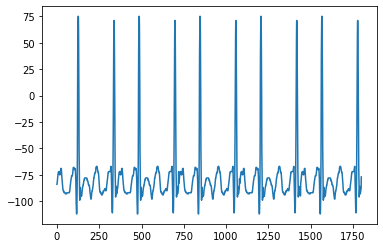

In [21]:
plt.plot(xTrain[-10, :, 0, 0])
xTrain.dtype

In [22]:
shuffle_index= np.arange(xTrain.shape[0])
random.shuffle(shuffle_index)
xTrain = xTrain[shuffle_index]
yTrain = yTrain[shuffle_index]

In [23]:
np.savetxt('./preprocessed data/xTrain.csv', xTrain.reshape(-1, datalen), delimiter=",")
np.savetxt('./preprocessed data/yTrain.csv', yTrain, delimiter=",")
np.savetxt('./preprocessed data/xTest.csv', xTest.reshape(-1, datalen), delimiter=",")
np.savetxt('./preprocessed data/yTest.csv', yTest, delimiter=",")
np.savetxt('./preprocessed data/yTest1.csv', yTest1, delimiter=",")

In [24]:
xTrain = np.array(pd.read_csv('./preprocessed data/xTrain.csv', header=None)).reshape(-1, datalen, 1, 1).astype(np.int8)
yTrain = np.array(pd.read_csv('./preprocessed data/yTrain.csv', header=None)).astype(np.int8)
xTest = np.array(pd.read_csv('./preprocessed data/xTest.csv', header=None)).reshape(-1, datalen, 1, 1).astype(np.int8)
yTest = np.array(pd.read_csv('./preprocessed data/yTest.csv', header=None)).astype(np.int8)
yTest1 = np.array(pd.read_csv('./preprocessed data/yTest1.csv', header=None)).flatten().astype(np.int8)

In [25]:
import numpy as np
import scipy.io as sio
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import os

tf.keras.backend.clear_session()

def ECGnet():
    input = Input(shape=(datalen,1,1))
    x = Conv2D(32, (50,1), strides=(2,1))(input)
    x = Conv2D(32, (15, 1), strides=(2, 1), padding="same")(x)
    for i in range(5):
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(32, (3, 1), strides=(2, 1), padding="same")(x)
   
    x = AveragePooling2D(pool_size=(x.shape[1], 1))(x)
    x = Flatten()(x)
    x = Dense(int(yTest1[-1])+1, activation="softmax")(x)
    return Model(inputs=input, outputs=x)


model = ECGnet()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1800, 1, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 876, 1, 32)        1632      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 438, 1, 32)        15392     
_________________________________________________________________
batch_normalization (BatchNo (None, 438, 1, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 438, 1, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 219, 1, 32)        3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 219, 1, 32)       

In [26]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_function = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.01)

In [28]:
history = model.fit(xTrain, yTrain, epochs=120,
                    batch_size=32, shuffle=True,
                    validation_split=0.1 , callbacks=[learning_rate_function])
#

Epoch 1/120
122/122 [==============================] - 8s 68ms/step - loss: 3.3305 - accuracy: 0.1183 - val_loss: 6.5310 - val_accuracy: 0.0625
Epoch 2/120
122/122 [==============================] - 9s 73ms/step - loss: 2.6000 - accuracy: 0.2734 - val_loss: 3.6725 - val_accuracy: 0.0926
Epoch 3/120
122/122 [==============================] - 9s 73ms/step - loss: 2.0793 - accuracy: 0.3976 - val_loss: 7.4813 - val_accuracy: 0.0787
Epoch 4/120
122/122 [==============================] - 9s 74ms/step - loss: 1.6370 - accuracy: 0.5162 - val_loss: 3.4437 - val_accuracy: 0.2824
Epoch 5/120
122/122 [==============================] - 9s 77ms/step - loss: 1.2540 - accuracy: 0.6281 - val_loss: 1.4208 - val_accuracy: 0.5995
Epoch 6/120
122/122 [==============================] - 10s 81ms/step - loss: 0.8995 - accuracy: 0.7477 - val_loss: 15.2510 - val_accuracy: 0.1273
Epoch 7/120
122/122 [==============================] - 10s 85ms/step - loss: 0.7627 - accuracy: 0.7996 - val_loss: 1.4099 - val_accura

122/122 [==============================] - 13s 105ms/step - loss: 0.0086 - accuracy: 0.9990 - val_loss: 0.0523 - val_accuracy: 0.9861
Epoch 53/120
122/122 [==============================] - 14s 112ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9838
Epoch 54/120
122/122 [==============================] - 13s 105ms/step - loss: 0.0109 - accuracy: 0.9987 - val_loss: 0.0483 - val_accuracy: 0.9861
Epoch 55/120
122/122 [==============================] - 13s 106ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 0.9884
Epoch 56/120
122/122 [==============================] - 13s 106ms/step - loss: 0.0094 - accuracy: 0.9992 - val_loss: 0.0475 - val_accuracy: 0.9884
Epoch 57/120
122/122 [==============================] - 13s 106ms/step - loss: 0.0088 - accuracy: 0.9992 - val_loss: 0.0473 - val_accuracy: 0.9838
Epoch 58/120
122/122 [==============================] - 13s 109ms/step - loss: 0.0096 - accuracy: 0.9995 - val_loss: 0.0509 - val_a

Epoch 108/120
122/122 [==============================] - 13s 106ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0488 - val_accuracy: 0.9861
Epoch 109/120
122/122 [==============================] - 13s 105ms/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.0520 - val_accuracy: 0.9884
Epoch 110/120
122/122 [==============================] - 13s 104ms/step - loss: 0.0065 - accuracy: 0.9995 - val_loss: 0.0489 - val_accuracy: 0.9838
Epoch 111/120
122/122 [==============================] - 13s 110ms/step - loss: 0.0074 - accuracy: 0.9992 - val_loss: 0.0481 - val_accuracy: 0.9815
Epoch 112/120
122/122 [==============================] - 13s 104ms/step - loss: 0.0063 - accuracy: 0.9995 - val_loss: 0.0503 - val_accuracy: 0.9861
Epoch 113/120
122/122 [==============================] - 13s 103ms/step - loss: 0.0071 - accuracy: 0.9992 - val_loss: 0.0492 - val_accuracy: 0.9792
Epoch 114/120
122/122 [==============================] - 13s 104ms/step - loss: 0.0059 - accuracy: 0.9997 - val_

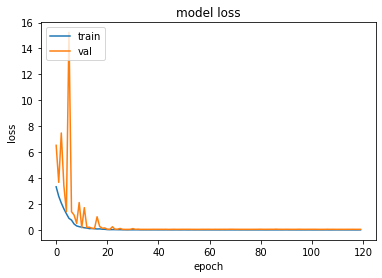

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

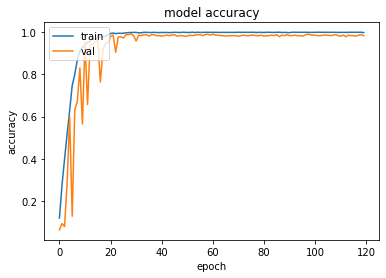

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
scores = model.evaluate(xTest, yTest)
scores[1]

59/59 [==============================] - 2s 33ms/step - loss: 0.0474 - accuracy: 0.9851


0.9851064085960388

## Quantization

In [32]:
test_data = tf.cast(xTest, tf.float32)
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]

In [33]:
# tensorflow lite quantize in int8
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen

tflite_model_quant_int8 = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmporw45q50\assets


In [34]:
import pathlib

tflite_models_dir = pathlib.Path("generated/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [35]:
tflite_model_quant_file_int8 = tflite_models_dir/"tflite_model_quant_int82.tflite"
tflite_model_quant_file_int8.write_bytes(tflite_model_quant_int8)

49856

## Evaluate TensorFlow Lite Model

In [36]:
X_test_data = tf.cast(xTest, tf.float32)

def evaluate_model(interpreter):
    global X_test_data
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_input_details()[0]['quantization']

    prediction_values = []
    
    for test_data in X_test_data:
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_data = np.expand_dims(test_data, axis=0)##.astype(interpreter.get_input_details()[0]["dtype"])
        test_data = np.int8(test_data / scale + zero_point)
        interpreter.set_tensor(input_index, test_data)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
#         print(output())
        result = np.argmax(output()[0])
        prediction_values.append(result)
    
    print(prediction_values)
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == yTest1[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

In [37]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file_int8))
interpreter.allocate_tensors()
print(str(evaluate_model(interpreter)) + "%")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 42, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 20, 3, 3, 3, 3, 3, 31, 3, 3, 31, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 19, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8